In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keep-babies-safe/dataset/test.csv
/kaggle/input/keep-babies-safe/dataset/images/998d55d3fd.jpg
/kaggle/input/keep-babies-safe/dataset/images/c4e61d99a4.jpg
/kaggle/input/keep-babies-safe/dataset/images/2976b42333.jpg
/kaggle/input/keep-babies-safe/dataset/images/3a8cb219ca.jpg
/kaggle/input/keep-babies-safe/dataset/images/cbe2de4f9a.jpg
/kaggle/input/keep-babies-safe/dataset/images/e731625992.jpg
/kaggle/input/keep-babies-safe/dataset/images/39ee899aaf.jpg
/kaggle/input/keep-babies-safe/dataset/images/8206078dea.jpg
/kaggle/input/keep-babies-safe/dataset/images/509273343e.jpg
/kaggle/input/keep-babies-safe/dataset/images/01f8ce31f6.jpg
/kaggle/input/keep-babies-safe/dataset/images/11185cd72b.jpg
/kaggle/input/keep-babies-safe/dataset/images/6fc905989a.jpg
/kaggle/input/keep-babies-safe/dataset/images/1464cb5150.jpg
/kaggle/input/keep-babies-safe/dataset/images/9dd6db5b67.jpg
/kaggle/input/keep-babies-safe/dataset/images/d9d3e36951.jpg
/kaggle/input/keep-babies-safe/datase

In [2]:
# installing keras ocr for future use
!pip install -q keras-ocr

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# Import the required packages and libraries
import sklearn
import os
import sys
import matplotlib.pyplot as plt
import cv2
import pytesseract
import numpy as np
import pandas as pd
import tensorflow as tf
conf = r'-- oem 2'
import keras_ocr

from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [4]:
data = pd.read_csv('/kaggle/input/keep-babies-safe/dataset/test.csv')
print(data.shape)
data.head()

(1131, 3)


,Image,Class_of_image,Brand_name
0,006a22fa50.jpg,NaN,NaN
1,01484e7348.jpg,NaN,NaN
2,015d91ab7b.jpg,NaN,NaN
3,01f8ce31f6.jpg,NaN,NaN
4,020e280221.jpg,NaN,NaN


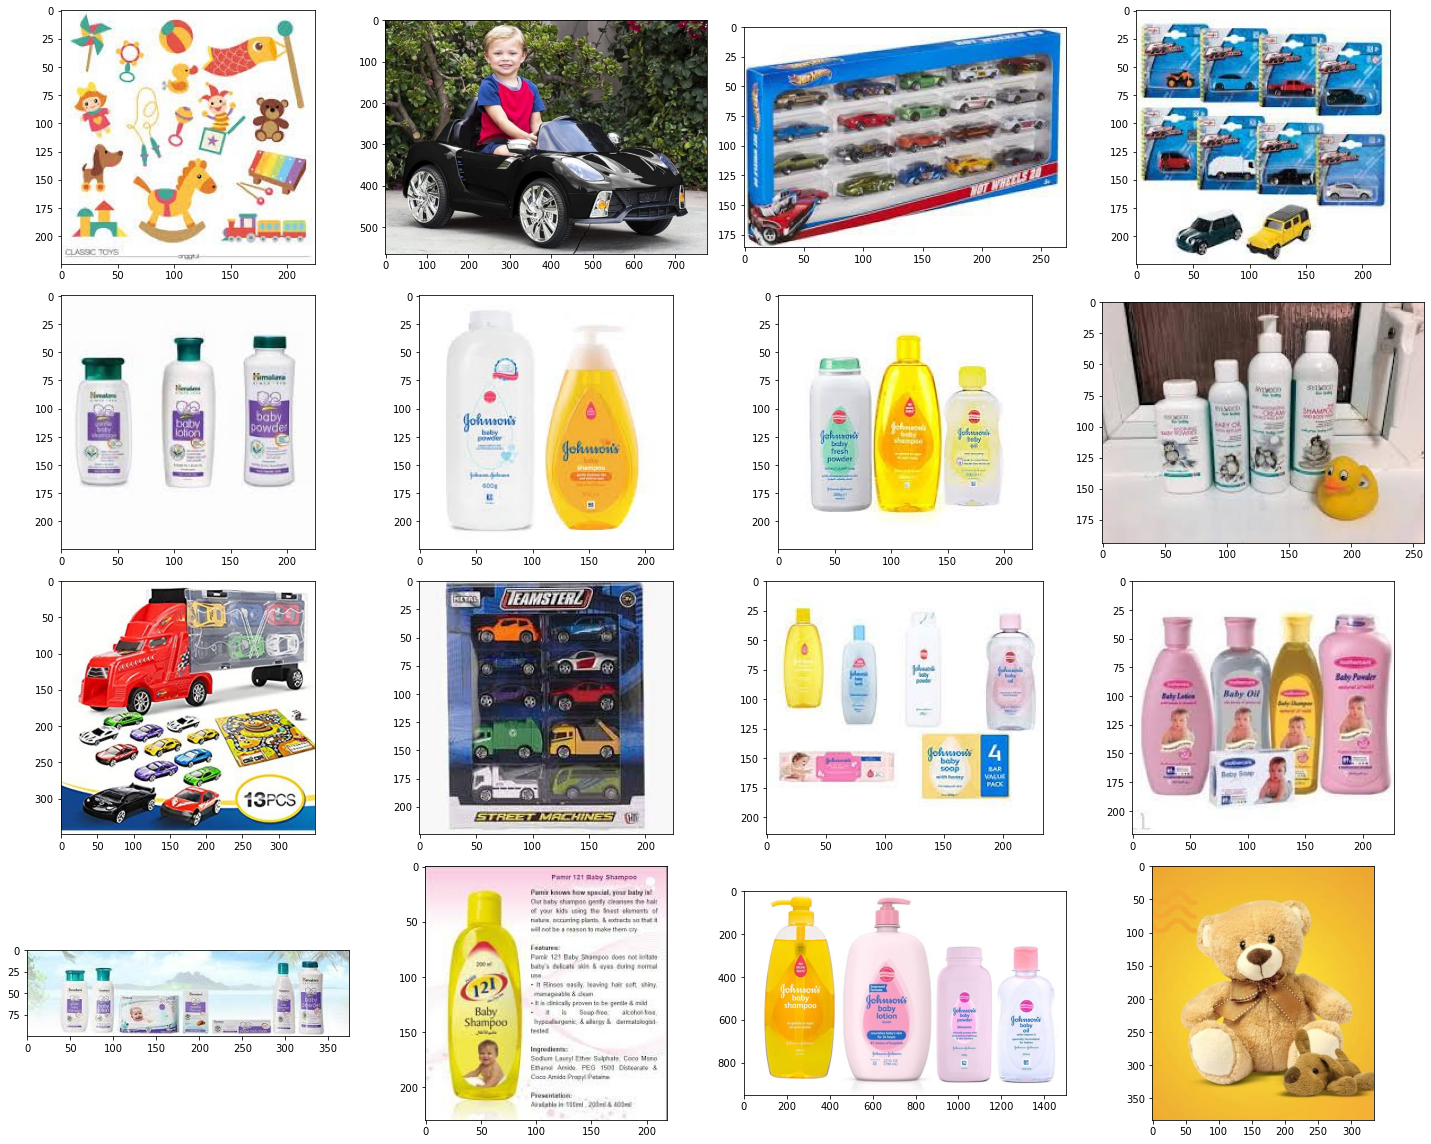

In [5]:
def display_samples(data, col=4, row=4):
    fig=plt.figure(figsize=(5*col, 4*row))

    for i in range(col*row):
        img_path = data.loc[i,'Image']
        img = cv2.imread(f'../input/keep-babies-safe/dataset/images/{img_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(row, col, i+1)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(data)

In [6]:
Data = {'image_name' : [],'flatten_image' : [],'text' : []}

In [7]:
# apply transfer learning using Resnet50 as the pretrained model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.ResNet101(include_top = False, weights='imagenet',    pooling='avg'))

171450368/171446536 [==============================] - 1s 0us/step


In [8]:
# freezing weights for 1st layer
model.layers[0].trainable = False

# USING PYTESSERACT OCR 

In [9]:
### Now defining dataloading Function
def LoadData(path, h, w):
    img = cv2.imread(path)
    Data['text'].append(pytesseract.image_to_string(img, config = conf))
    img = cv2.resize(img, (h, w))
    # expanding image dims so this represents 1 sample
    img = img = np.expand_dims(img, 0)
    
    # preprocesssing the images with resnet 50
    img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = model.predict(img)
    extractedFeatures = np.array(extractedFeatures)
    Data['flatten_image'].append(extractedFeatures.flatten()) # flattening the whole array into a single dimension

In [10]:
# reading and storing the images
def ReadStore(path):
    list_ = os.listdir(path)
    for img_index in list_:
        Data['image_name'].append(img_index)
        imagePath = path + '/' + img_index
        LoadData(imagePath, 224, 224)

In [11]:
### lets give the address of our Parent directory and start
path = '/kaggle/input/keep-babies-safe/dataset/images'
ReadStore(path)

In [12]:
# Implementing clustering for classifying the images into two categories

training_feature_vector = np.array(Data['flatten_image'], dtype = 'float64')

kmeans = AgglomerativeClustering(n_clusters = 2)
kmeans.fit(training_feature_vector)

AgglomerativeClustering()

In [13]:
# predicting the labels and assigning them 'values'
predictions = kmeans.labels_
NamePred = []
for img_index in predictions:
    if img_index == 0:
        NamePred.append('toys')
    else:
        NamePred.append('Consumer_Products')

In [14]:
# Collecting the brand names
textAns = np.array(Data['text'])
realText = []
import re

for img_index in textAns:
    new_index = re.sub("\s\s+", " ", img_index)
    if len(new_index) == 0 or new_index == " ":
        realText.append('Unnamed')
        continue
    else:
        realText.append(str(new_index))


In [15]:
names = Data['image_name']
df = {
    'Image' : names,
    'Class' : NamePred,
    'Brand_Name' : realText
}
df = pd.DataFrame(df)
df.to_csv('pred_tesseract.csv', index = False)

In [16]:
df.head(20)

,Image,Class,Brand_Name
0,998d55d3fd.jpg,toys,Unnamed
1,c4e61d99a4.jpg,toys,Unnamed
2,2976b42333.jpg,Consumer_Products,BD. @ @ A
3,3a8cb219ca.jpg,Consumer_Products,Unnamed
4,cbe2de4f9a.jpg,Consumer_Products,Unnamed
5,e731625992.jpg,toys,Unnamed
6,39ee899aaf.jpg,Consumer_Products,Unnamed
7,8206078dea.jpg,Consumer_Products,Littles
8,509273343e.jpg,toys,Unnamed
9,01f8ce31f6.jpg,toys,Unnamed


In [17]:
'''
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "Pytesseract.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
df = pd.DataFrame(df)

# create a link to download the dataframe
create_download_link(df)
'''

'\n# import the modules we\'ll need\nfrom IPython.display import HTML\nimport pandas as pd\nimport numpy as np\nimport base64\n\n# function that takes in a dataframe and creates a text link to  \n# download it (will only work for files < 2MB or so)\ndef create_download_link(df, title = "Download CSV file", filename = "Pytesseract.csv"):  \n    csv = df.to_csv()\n    b64 = base64.b64encode(csv.encode())\n    payload = b64.decode()\n    html = \'<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>\'\n    html = html.format(payload=payload,title=title,filename=filename)\n    return HTML(html)\n\n# create a random sample dataframe\ndf = pd.DataFrame(df)\n\n# create a link to download the dataframe\ncreate_download_link(df)\n'

# **EVALUATING THE ACCURACY OF THE MODEL ON TESTING SET**

> **We use error rates to determine the extent to which the OCR transcribed text and ground truth text (i.e., reference text labeled manually) differ from each other.**

> There are three types of errors to consider:
> * **Substitution error**: Misspelled characters/words
> * **Deletion error**: Lost or missing characters/words
> * **Insertion error**: Incorrect inclusion of character/words

In [31]:
# Create new columns for reference, CER and WER
df['ref_text'] = ''
df['cer'] = ''
df['wer'] = ''

# Replace new lines in output
df.loc[df['Image'] == '2976b42333.jpg', 'ref_text'] = "Baby Series baby powder baby lotion baby baby oil"
df.loc[df['Image'] == '2705c1f073.jpg', 'ref_text'] = "Infrared Ray Receiver Pressure Bullet Sensor Rearlights Sound"
df.loc[df['Image'] == '509273343e.jpg', 'ref_text'] = "Unnamed"
df.loc[df['Image'] == '3358b724a2.jpg', 'ref_text'] = "LIMITED TIME ONLY SPECIAL OFFER @ |Buy minimum 6 quantity and get special discount of 15% with free shipping"
df.loc[df['Image'] == '58b6fa342e.jpg', 'ref_text'] = "Unnamed"
df.loc[df['Image'] == 'c8f69d11f3.jpg', 'ref_text'] = "VERB GENTLE CLEANSE + LIGHT VOLUME DRY SHAMPOO NETTOYAGE DOUX + VOLUME LEGER SHAMPOOING SEC me So1mle aVRB O52 turally luxe beauty THE DO GOODERâ„¢ RM Net wae SHAMPOOING SEC VOLUMISANT CHARME INTEGRA residue-free quick cleaning bounce boosting style extending Pr ec plus de corps seme a Vv RCT ceays "
df.loc[df['Image'] == '66c710ba7a.jpg', 'ref_text'] = "a alamy stock photo MCBW18"
df.loc[df['Image'] == '79e8392a5a.jpg', 'ref_text'] = "BATTERY OPERATED CAR"
df.loc[df['Image'] == '809dd92617.jpg', 'ref_text'] = "Mahavir traders"
df.loc[df['Image'] == 'e5beeb7231.jpg', 'ref_text'] = "Contents of the Basket Baby massage oil (100 ml) Diaper rash cream (20g) gentle bab wipes Baby Cream (50 ml) Baby Powder (100 g)"
df.loc[df['Image'] == 'ec87a29964.jpg', 'ref_text'] = "Advanced Baby Bath & Skin Care"
df.loc[df['Image'] == 'c0348bd355.jpg', 'ref_text'] = "F"

In [32]:
df

,Image,Class,Brand_Name,ref_text,cer,wer
0,998d55d3fd.jpg,toys,Unnamed,,,
1,c4e61d99a4.jpg,toys,Unnamed,,,
2,2976b42333.jpg,Consumer_Products,BD. @ @ A,Baby Series baby powder baby lotion baby baby oil,,
3,3a8cb219ca.jpg,Consumer_Products,Unnamed,,,
4,cbe2de4f9a.jpg,Consumer_Products,Unnamed,,,
...,...,...,...,...,...,...
1126,ad45cf0240.jpg,toys,Unnamed,,,
1127,fe311dccc8.jpg,Consumer_Products,oo Bat 6) dreamstime.com ID 186378097 © Byciri...,,,
1128,acd709d96b.jpg,toys,,,,
1129,58b6fa342e.jpg,Consumer_Products,Unnamed,Unnamed,,


> **CER calculation is based on the concept of Levenshtein distance, where we count the minimum number of character-level operations required to transform the ground truth text (aka reference text) into the OCR output.**

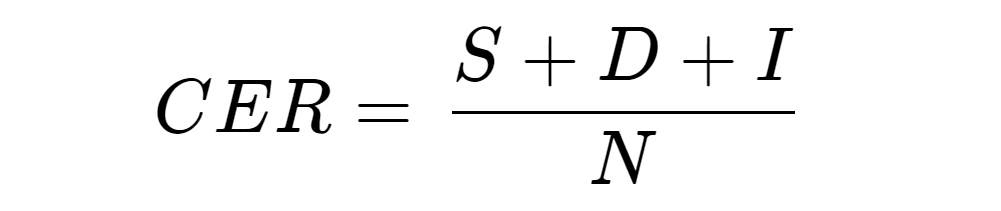

* > S = Number of Substitutions
* > D = Number of Deletions
* > I = Number of Insertions
* > N = Number of characters in reference text (aka ground truth)

> **Word Error Rate might be more applicable if it involves the transcription of paragraphs and sentences of words with meaning (e.g., pages of books, newspapers).**

> WER operates at the word level instead. It represents the number of word substitutions, deletions, or insertions needed to transform one sentence into another.

> WER is generally well-correlated with CER (provided error rates are not excessively high), although the absolute WER value is expected to be higher than the CER value.

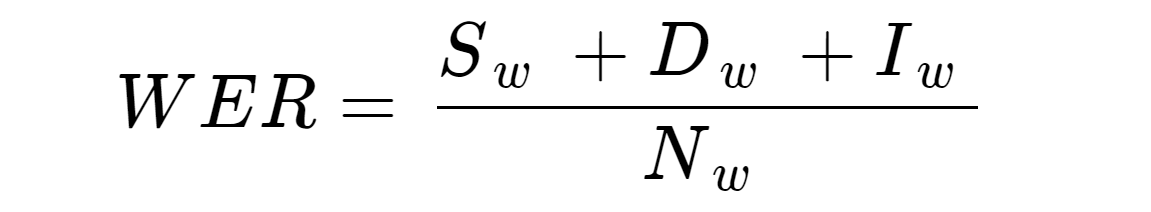

In [20]:
!pip install fastwer

  Created wheel for fastwer: filename=fastwer-0.1.3-cp37-cp37m-linux_x86_64.whl size=577634 sha256=8484adb1e7ab1abed015fa781f7eb0a08cf8444e894feba6e2a088c7301d119b
  Stored in directory: /root/.cache/pip/wheels/c8/b6/93/419e758f0c0176d311602763520bcfdec18107be1f15186fe6
Successfully built fastwer
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [33]:
import fastwer

for index, row in df.iterrows():
  filename = row['Image']
  ref = row['ref_text']
  output = row['Brand_Name']
  #if row['ref_text']!='inf':
  cer = fastwer.score_sent(output, ref, char_level=True)
  wer = fastwer.score_sent(output, ref, char_level=False)
  df.loc[df['Image'] == filename, 'cer'] = round(cer,2) # Round value to 2 decimal places
  df.loc[df['Image'] == filename, 'wer'] = round(wer,2)

df

,Image,Class,Brand_Name,ref_text,cer,wer
0,998d55d3fd.jpg,toys,Unnamed,,inf,inf
1,c4e61d99a4.jpg,toys,Unnamed,,inf,inf
2,2976b42333.jpg,Consumer_Products,BD. @ @ A,Baby Series baby powder baby lotion baby baby oil,89.8,100
3,3a8cb219ca.jpg,Consumer_Products,Unnamed,,inf,inf
4,cbe2de4f9a.jpg,Consumer_Products,Unnamed,,inf,inf
...,...,...,...,...,...,...
1126,ad45cf0240.jpg,toys,Unnamed,,inf,inf
1127,fe311dccc8.jpg,Consumer_Products,oo Bat 6) dreamstime.com ID 186378097 © Byciri...,,inf,inf
1128,acd709d96b.jpg,toys,,,inf,inf
1129,58b6fa342e.jpg,Consumer_Products,Unnamed,Unnamed,0,0


In [34]:
# Replacing infinity (inf) values with nan values and dropping the rows containing nan
new_df = df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]  # .astype(np.float64) ?

In [35]:
new_df

,Image,Class,Brand_Name,ref_text,cer,wer
2,2976b42333.jpg,Consumer_Products,BD. @ @ A,Baby Series baby powder baby lotion baby baby oil,89.8,100
8,509273343e.jpg,toys,Unnamed,Unnamed,0,0
250,3358b724a2.jpg,Consumer_Products,LIMITED TIME ONLY SPECIAL OFFER @ |Buy minimum...,LIMITED TIME ONLY SPECIAL OFFER @ |Buy minimum...,12.04,47.37
323,2705c1f073.jpg,toys,Infrared Ray Recoiver Pressure Bullet Sonsor R...,Infrared Ray Receiver Pressure Bullet Sensor R...,8.2,50
440,c0348bd355.jpg,toys,F,F,100,0
907,c8f69d11f3.jpg,Consumer_Products,VERB GENTLE CLEANSE + LIGHT VOLUME DRY SHAMPOO...,VERB GENTLE CLEANSE + LIGHT VOLUME DRY SHAMPOO...,23.68,36
928,66c710ba7a.jpg,toys,a EJ alamy stock photo cee,a alamy stock photo MCBW18,34.62,40
1038,e5beeb7231.jpg,Consumer_Products,Contents of the Basket Baby massage\nil (100 m...,Contents of the Basket Baby massage oil (100 m...,21.88,41.67
1047,ec87a29964.jpg,Consumer_Products,> Advanced Baby Bath\n@ Skin Care,Advanced Baby Bath & Skin Care,16.67,50
1072,809dd92617.jpg,toys,Unnamed,Mahavir traders,86.67,100


In [36]:
# Taking the mean of CER and WER
from statistics import mean

# Overall performances
mean_cer = new_df['cer'].mean()
mean_wer = new_df['wer'].mean()
print(f'Mean CER = {mean_cer}%, Mean WER = {mean_wer}%')

Mean CER = 33.21333333333334%, Mean WER = 38.75333333333334%


# USING KERAS OCR

**keras-ocr provides out-of-the-box OCR models and an end-to-end training pipeline to build new OCR models. Using keras-ocr for getting text from images.**

In [37]:
DataFrame = {'image_name' : [],'flatten_image' : [],'text' : [] }

In [38]:
# downloading weights for keras ocr
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [39]:
# defining dataloading Function
def LoadData(path_new, h, w):
    img = keras_ocr.tools.read(path_new)
    #result = reader.readtext(img) # [0]
    DataFrame['text'].append(pipeline.recognize([img]))
    img = cv2.resize(img, (h, w))

    img = img = np.expand_dims(img, 0)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = model.predict(img)
    extractedFeatures = np.array(extractedFeatures)
    DataFrame['flatten_image'].append(extractedFeatures.flatten())

In [40]:
# reading and storing the images
def ReadStore(path_new):
    list_ = os.listdir(path_new)
    for img_index in list_:
        DataFrame['image_name'].append(img_index)
        imagePath = path_new + '/' + img_index
        LoadData(imagePath, 224, 224)

In [41]:
path_new = '/kaggle/input/keep-babies-safe/dataset/images'
ReadStore(path_new)

In [42]:
Training_Feature_vector = np.array(DataFrame['flatten_image'], dtype = 'float64')
from sklearn.cluster import AgglomerativeClustering
kmeans = AgglomerativeClustering(n_clusters = 2)
kmeans.fit(Training_Feature_vector)

AgglomerativeClustering()

In [43]:
predictions = kmeans.labels_
NamePred = []
for mem in predictions:
    if mem == 0:
        NamePred.append('toys')
    else:
        NamePred.append('Consumer_Products')

In [44]:
names = DataFrame['image_name']
brand = DataFrame['text']
df = {
    'Image' : names,
    'Class' : NamePred,
    'Brand_Name' : brand
}
df = pd.DataFrame(df)
df.to_csv('pred_keras.csv', index = False)

In [45]:
df.sample(20)

,Image,Class,Brand_Name
755,b05c55027b.jpg,Consumer_Products,[[]]
245,7e0a4a2c3a.jpg,Consumer_Products,"[[(johnsons, [[327. 138.]\n [416. 138.]\n [416..."
43,e6b8507f83.jpg,toys,"[[(d, [[323.5298 309.77722]\n [410.59296 288...."
268,e9d12a012c.jpg,toys,"[[(gad, [[20. 10.]\n [44. 10.]\n [44. 29.]\n [..."
187,0c80e323ff.jpg,toys,"[[(techwill, [[ 29. 38.]\n [193. 38.]\n [193..."
121,765512a0ee.jpg,Consumer_Products,"[[(tub, [[161. 183.]\n [195. 183.]\n [195. 202..."
243,d84cfe9af4.jpg,toys,[[]]
333,54ba0b0e65.jpg,toys,"[[(kiswn, [[255.17987 481.39172]\n [298.86862 ..."
110,be9d23ea69.jpg,toys,[[]]
162,c4e391c4de.jpg,Consumer_Products,[[]]


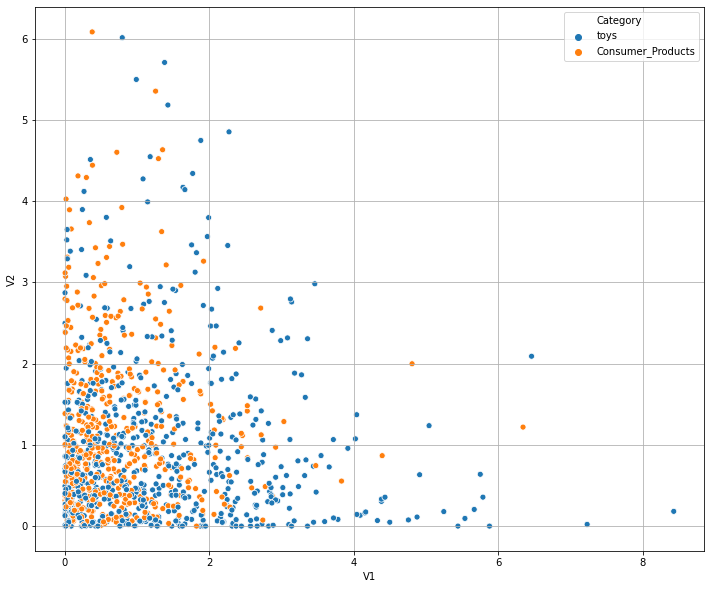

In [47]:
import seaborn as sb

ReducedKerasDataFrame = pd.DataFrame(Training_Feature_vector)
ReducedKerasDataFrame = ReducedKerasDataFrame.rename(columns = { 0: 'V1', 1 : 'V2'})
ReducedKerasDataFrame['Category'] = list (df['Class'])
plt.figure(figsize = (12, 10))
sb.scatterplot(data = ReducedKerasDataFrame, x = 'V1', y = 'V2',hue = 'Category')
plt.grid(True)
plt.show()

# **EVALUATING THE ACCURACY OF THE MODEL ON TESTING SET**

In [48]:
# Create new columns for reference, CER and WER
df['ref_text'] = ''
df['cer'] = ''
df['wer'] = ''

# Replace new lines in output
df.loc[df['Image'] == '2976b42333.jpg', 'ref_text'] = "Baby Series baby powder baby lotion baby baby oil"
df.loc[df['Image'] == '2705c1f073.jpg', 'ref_text'] = "Infrared Ray Receiver Pressure Bullet Sensor Rearlights Sound"
df.loc[df['Image'] == '509273343e.jpg', 'ref_text'] = "Unnamed"
df.loc[df['Image'] == '3358b724a2.jpg', 'ref_text'] = "LIMITED TIME ONLY SPECIAL OFFER @ |Buy minimum 6 quantity and get special discount of 15% with free shipping"
df.loc[df['Image'] == '58b6fa342e.jpg', 'ref_text'] = "Unnamed"
df.loc[df['Image'] == 'c8f69d11f3.jpg', 'ref_text'] = "VERB GENTLE CLEANSE + LIGHT VOLUME DRY SHAMPOO NETTOYAGE DOUX + VOLUME LEGER SHAMPOOING SEC me So1mle aVRB O52 turally luxe beauty THE DO GOODERâ„¢ RM Net wae SHAMPOOING SEC VOLUMISANT CHARME INTEGRA residue-free quick cleaning bounce boosting style extending Pr ec plus de corps seme a Vv RCT ceays "
df.loc[df['Image'] == '66c710ba7a.jpg', 'ref_text'] = "a alamy stock photo MCBW18"
df.loc[df['Image'] == '79e8392a5a.jpg', 'ref_text'] = "BATTERY OPERATED CAR"
df.loc[df['Image'] == '809dd92617.jpg', 'ref_text'] = "Mahavir traders"
df.loc[df['Image'] == 'e5beeb7231.jpg', 'ref_text'] = "Contents of the Basket Baby massage oil (100 ml) Diaper rash cream (20g) gentle bab wipes Baby Cream (50 ml) Baby Powder (100 g)"
df.loc[df['Image'] == 'ec87a29964.jpg', 'ref_text'] = "Advanced Baby Bath & Skin Care"
df.loc[df['Image'] == 'c0348bd355.jpg', 'ref_text'] = "F"

In [49]:
df

,Image,Class,Brand_Name,ref_text,cer,wer
0,998d55d3fd.jpg,toys,[[]],,,
1,c4e61d99a4.jpg,toys,"[[(vx, [[ 99. 231.]\n [129. 231.]\n [129. 260....",,,
2,2976b42333.jpg,Consumer_Products,"[[(iso, [[159. 32.]\n [193. 32.]\n [193. 51...",Baby Series baby powder baby lotion baby baby oil,,
3,3a8cb219ca.jpg,Consumer_Products,"[[(puncid, [[ 63. 102.]\n [111. 102.]\n [111. ...",,,
4,cbe2de4f9a.jpg,Consumer_Products,"[[(johwon, [[168.80002 32.400017]\n [183.6 ...",,,
...,...,...,...,...,...,...
1126,ad45cf0240.jpg,toys,"[[(poneh, [[632.11694 368.6646 ]\n [675.3231 ...",,,
1127,fe311dccc8.jpg,Consumer_Products,"[[(dreamstime, [[ 76.56252 221.87503]\n [202.3...",,,
1128,acd709d96b.jpg,toys,[[]],,,
1129,58b6fa342e.jpg,Consumer_Products,[[]],Unnamed,,


In [51]:
df['Brand_Name']= df['Brand_Name'].map(str)

In [52]:
import fastwer

for index, row in df.iterrows():
  filename = row['Image']
  ref = row['ref_text']
  output = row['Brand_Name']
  #if row['ref_text']!='inf':
  cer = fastwer.score_sent(output, ref, char_level=True)
  wer = fastwer.score_sent(output, ref, char_level=False)
  df.loc[df['Image'] == filename, 'cer'] = round(cer,2) # Round value to 2 decimal places
  df.loc[df['Image'] == filename, 'wer'] = round(wer,2)

df

,Image,Class,Brand_Name,ref_text,cer,wer
0,998d55d3fd.jpg,toys,[[]],,inf,inf
1,c4e61d99a4.jpg,toys,"[[('vx', array([[ 99., 231.],\n [129., 2...",,inf,inf
2,2976b42333.jpg,Consumer_Products,"[[('iso', array([[159., 32.],\n [193., ...",Baby Series baby powder baby lotion baby baby oil,12469.4,16433.3
3,3a8cb219ca.jpg,Consumer_Products,"[[('puncid', array([[ 63., 102.],\n [111...",,inf,inf
4,cbe2de4f9a.jpg,Consumer_Products,"[[('johwon', array([[168.80002 , 32.400017],\...",,inf,inf
...,...,...,...,...,...,...
1126,ad45cf0240.jpg,toys,"[[('poneh', array([[632.11694, 368.6646 ],\n ...",,inf,inf
1127,fe311dccc8.jpg,Consumer_Products,"[[('dreamstime', array([[ 76.56252, 221.87503]...",,inf,inf
1128,acd709d96b.jpg,toys,[[]],,inf,inf
1129,58b6fa342e.jpg,Consumer_Products,[[]],Unnamed,100,100


In [54]:
# Replacing infinity (inf) values with nan values and dropping the rows containing nan
new_keras_df = df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
new_keras_df

,Image,Class,Brand_Name,ref_text,cer,wer
2,2976b42333.jpg,Consumer_Products,"[[('iso', array([[159., 32.],\n [193., ...",Baby Series baby powder baby lotion baby baby oil,12469.4,16433.3
8,509273343e.jpg,toys,[[]],Unnamed,100,100
250,3358b724a2.jpg,Consumer_Products,"[[('limited', array([[244., 15.],\n [31...",LIMITED TIME ONLY SPECIAL OFFER @ |Buy minimum...,3023.15,4115.79
323,2705c1f073.jpg,toys,"[[('infrared', array([[ 3., 19.],\n [43....",Infrared Ray Receiver Pressure Bullet Sensor R...,1637.7,3387.5
440,c0348bd355.jpg,toys,[[]],F,400,100
907,c8f69d11f3.jpg,Consumer_Products,"[[('caci', array([[1279.6875, 273.4375],\n ...",VERB GENTLE CLEANSE + LIGHT VOLUME DRY SHAMPOO...,3659.21,5560
928,66c710ba7a.jpg,toys,"[[('a', array([[658.8867 , 27.929688],\n ...",a alamy stock photo MCBW18,16600,20120
1038,e5beeb7231.jpg,Consumer_Products,"[[('of', array([[470., 10.],\n [488., ...",Contents of the Basket Baby massage oil (100 m...,4317.97,6033.33
1047,ec87a29964.jpg,Consumer_Products,"[[('advanced', array([[117., 27.],\n [1...",Advanced Baby Bath & Skin Care,5143.33,7466.67
1072,809dd92617.jpg,toys,"[[('matavir', array([[ 6., 4.],\n [47.,...",Mahavir traders,2846.67,6100


In [55]:
# Taking the mean of CER and WER
from statistics import mean

# Overall performances
mean_cer_keras = new_keras_df['cer'].mean()
mean_wer_keras = new_keras_df['wer'].mean()
print(f'Mean CER = {mean_cer_keras}%, Mean WER = {mean_wer_keras}%')

Mean CER = 4644.368333333333%, Mean WER = 6648.607499999999%


**After comparing the CER and WER accuracies of Tesseract OCR and Keras-OCR, we can conclude that for this case Pytesseract will be a better fit as it has a lower CER and WER as compared to Keras-OCR, hence better accuracy.**